In [1]:
import pandas as pd
import numpy as np, os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Data

In [2]:
folder_path = u'C:/Users/user/Desktop/AI-project/features/128' 

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)


In [3]:
folder_path = u'C:/Users/user/Desktop/AI-project/features/250' 

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_250.csv')]

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

# Label mapping

In [4]:
#Sobstitute N, S, V with 0, 1, 2
label_mapping = {'N': 0, 'S': 1, 'V': 2}
for data in all_data_list:
    data['annotation'] = data['annotation'].replace(label_mapping)

# Drop positions columns    

In [6]:
#drop the columns which contain positional info
#for i in range(len(all_data_list)):
#    all_data_list[i] = all_data_list[i].drop(['peak_pos', 'onset', 'diastolic_notch'], axis=1)

In [7]:
all_data_list[0]

,asp,adp,adn,rp,d1,d2,rd,rn,T1,T2,TP,ST,pi2pi_pr,pi2pi_po,area_peak,annotation
0,0.055274,0.823215,0.886627,0.719899,0.042081,0.425326,0.723122,0.288666,0.024067,0.643411,0.967991,0.210000,0.000000,0.015020,0.000992,0
1,0.045354,0.814343,0.884302,0.712917,0.040983,0.423003,0.726116,0.288231,0.024067,0.232558,0.909492,0.229630,0.027357,0.015020,0.000561,0
2,0.045747,0.813519,0.884597,0.712486,0.040809,0.422454,0.726397,0.288305,0.022864,0.232558,0.910596,0.228571,0.027357,0.015020,0.000578,0
3,0.047270,0.813824,0.885389,0.713275,0.040509,0.422070,0.726600,0.288490,0.022864,0.240310,0.911700,0.227586,0.027357,0.008678,0.000659,0
4,0.036112,0.818934,0.883222,0.712234,0.038791,0.425694,0.724313,0.287615,0.027677,0.201550,0.901766,0.240000,0.021094,0.020360,0.000249,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,0.046900,0.811773,0.884741,0.711761,0.041072,0.421604,0.726617,0.288342,0.025271,0.279070,0.915011,0.225000,0.031641,0.018358,0.000684,0
1956,0.049071,0.812713,0.885598,0.713176,0.040937,0.421452,0.726687,0.288525,0.025271,0.279070,0.915011,0.225000,0.030653,0.017356,0.000793,0
1957,0.047486,0.813713,0.876084,0.713276,0.050609,0.428090,0.762211,0.286395,0.036101,0.333333,0.912804,0.226667,0.029664,0.051736,0.002078,0
1958,0.049821,0.810715,0.870102,0.712228,0.057901,0.430694,0.737648,0.285364,0.046931,0.488372,0.924945,0.219512,0.063612,0.112483,0.005547,0


# Divide train/test

In [8]:
# Split Data
#A list of all csv is gived: because each element of a list represent a patient,
# a patient will stay only or in train or in test
train_list, test_list = train_test_split(all_data_list, test_size=0.2, random_state=42)
#train_list, val_list = train_test_split(train_list, test_size=0.2, random_state=42)

In [9]:
#Create a dataframe only for train and one for all test data
train_data = pd.DataFrame()
i = 0
for train in train_list:
    train_data = pd.concat([train_data, train], ignore_index=True)
    i = i + 1

In [10]:
# Model Training
X_train = train_data.drop('annotation', axis=1)
y_train = train_data['annotation']

In [11]:
# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['annotation'])

one_hot_encoded_array_train = one_hot_encoded_df.values

print(one_hot_encoded_df)
print(one_hot_encoded_array_train)

           0      1      2
0       True  False  False
1       True  False  False
2       True  False  False
3       True  False  False
4       True  False  False
...      ...    ...    ...
137339  True  False  False
137340  True  False  False
137341  True  False  False
137342  True  False  False
137343  True  False  False

[137344 rows x 3 columns]
[[ True False False]
 [ True False False]
 [ True False False]
 ...
 [ True False False]
 [ True False False]
 [ True False False]]


In [11]:

'''
val_data = pd.DataFrame()

for val in val_list:
    val_data = pd.concat([val_data, val], ignore_index=True) '''

'\nval_data = pd.DataFrame()\n\nfor val in val_list:\n    val_data = pd.concat([val_data, val], ignore_index=True) '

In [12]:
'''X_val = val_data.drop('annotation', axis=1)
y_val = val_data['annotation'] '''

"X_val = val_data.drop('annotation', axis=1)\ny_val = val_data['annotation'] "

In [13]:
'''one_hot_encoded_df_val = pd.get_dummies(y_val, columns=['annotation'])

one_hot_encoded_array_val = one_hot_encoded_df_val.values '''

"one_hot_encoded_df_val = pd.get_dummies(y_val, columns=['annotation'])\n\none_hot_encoded_array_val = one_hot_encoded_df_val.values "

In [12]:
test_data = pd.DataFrame()

for test in test_list:
    test_data = pd.concat([test_data, test], ignore_index=True)

In [13]:
X_test = test_data.drop('annotation', axis=1)
y_test= test_data['annotation']

In [14]:
one_hot_encoded_df_test = pd.get_dummies(y_test, columns=['annotation'])

one_hot_encoded_array_test = one_hot_encoded_df_test.values

In [15]:
N_train = (y_train == 0).sum() 
S_train = (y_train == 1).sum() 
V_train = (y_train == 2).sum() 
'''
N_val = (y_val == 0).sum() 
S_val = (y_val == 1).sum() 
V_val = (y_val == 2).sum() 

'''
N_test = (y_test == 0).sum() 
S_test = (y_test == 1).sum() 
V_test = (y_test == 2).sum() 

N_perc = N_train/(N_train+S_train+V_train)
S_perc = S_train/(N_train+S_train+V_train)
V_perc = V_train/(N_train+S_train+V_train)
print(f"Perc di N in train: {N_perc}")
print(f"Perc di S in train: {S_perc}")
print(f"Perc di V in train: {V_perc}")
'''
N_perc = N_val/(N_val+S_val+V_val)
S_perc = S_val/(N_val+S_val+V_val)
V_perc = V_val/(N_val+S_val+V_val)
'''
print(f"Perc di S in val: {N_perc}")
print(f"Perc di S in val: {S_perc}")
print(f"Perc di S in val: {V_perc}")

N_perc = N_test/(N_test+S_test+V_test)
S_perc = S_test/(N_test+S_test+V_test)
V_perc = V_test/(N_test+S_test+V_test)
print(f"Perc di S in test: {N_perc}")
print(f"Perc di S in test: {S_perc}")
print(f"Perc di S in test: {V_perc}")


Perc di N in train: 0.9240884203168686
Perc di S in train: 0.04832391658900279
Perc di V in train: 0.027587663094128613
Perc di S in val: 0.9240884203168686
Perc di S in val: 0.04832391658900279
Perc di S in val: 0.027587663094128613
Perc di S in test: 0.9049530732924645
Perc di S in test: 0.03013616882764607
Perc di S in test: 0.06491075787988933


# Evaluation function

In [16]:
# produce a normalized convulational matrix
def model_evaluation(y_predi, model_name_pred):

    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    cm = confusion_matrix(test_classes, predicted_class)
    classes_name = ['N', 'S', 'V']
    
    
    #Normalized cm
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name_pred)
    plt.show()

In [41]:
def downsample_majority_class(df, class_column):
    
    # Calculate the class counts
    class_counts = df[class_column].value_counts()
    
    print(class_counts)

    # Find the maximum value among the two least represented classes
    min_class_size = class_counts.nsmallest(2).max()

    subsampled_df = pd.DataFrame()

    for class_label in class_counts.index:
        class_subset = df[df[class_column] == class_label]

        # Downsample if this is the majority class
        if class_counts[class_label] > min_class_size:
            class_subset = class_subset.sample(n=min_class_size, random_state=42)
        
        subsampled_df = pd.concat([subsampled_df, class_subset], ignore_index=True)
        
    class_counts_sub = subsampled_df[class_column].value_counts()
    print(class_counts_sub)

    return subsampled_df

# Models

In [17]:
nN = np.count_nonzero(y_train == 0)
nV = np.count_nonzero(y_train == 1)
nS = np.count_nonzero(y_train == 2)

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wV = round(1-(nV/class_sum),2)  
wS = round(1-(nS/class_sum),2)

class_weights = {0: wN, 1: wV, 2: wS}

print(class_weights)

{0: 0.08, 1: 0.95, 2: 0.97}


# Grid search

In [21]:
'''from sklearn.model_selection import GridSearchCV

parameter_grid = { 
    'n_estimators': [50, 100],
    'max_features': [None, 'sqrt', 'log2', 3],
    'max_depth' : [10, 15],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' : [22, 42]
}
my_model = RandomForestClassifier()
clf = GridSearchCV(my_model, parameter_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 1)
clf.fit(X_train, y_train)
from sklearn import metrics
print(clf.best_params_)
print(clf.best_score_)
'''

"from sklearn.model_selection import GridSearchCV\n\nparameter_grid = { \n    'n_estimators': [50, 100],\n    'max_features': [None, 'sqrt', 'log2', 3],\n    'max_depth' : [10, 15],\n    'criterion' :['gini', 'entropy'],\n    'min_samples_split' : [22, 42]\n}\nmy_model = RandomForestClassifier()\nclf = GridSearchCV(my_model, parameter_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 1)\nclf.fit(X_train, y_train)\nfrom sklearn import metrics\nprint(clf.best_params_)\nprint(clf.best_score_)\n"

# K-NN

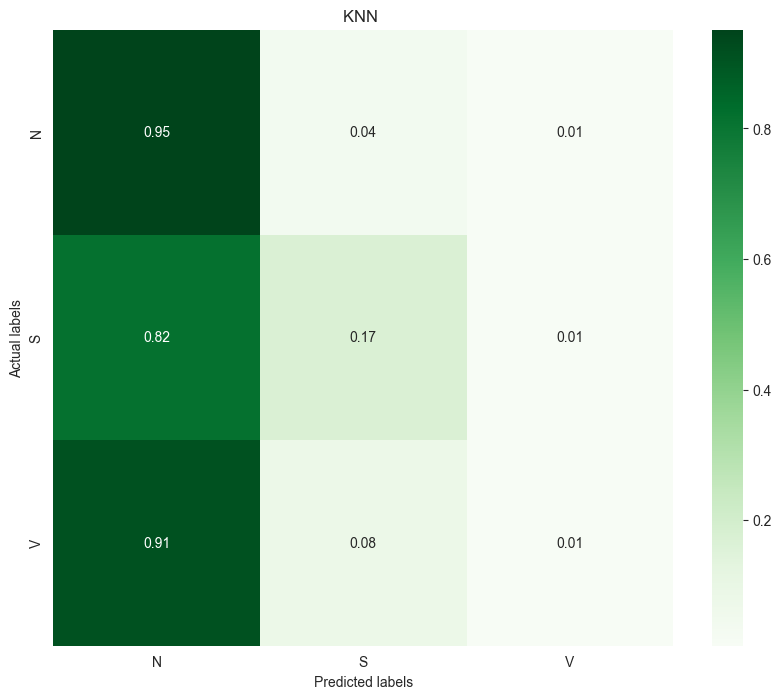

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
    
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])
model_evaluation(one_hot_encoded_pred, "KNN ")


# SVM

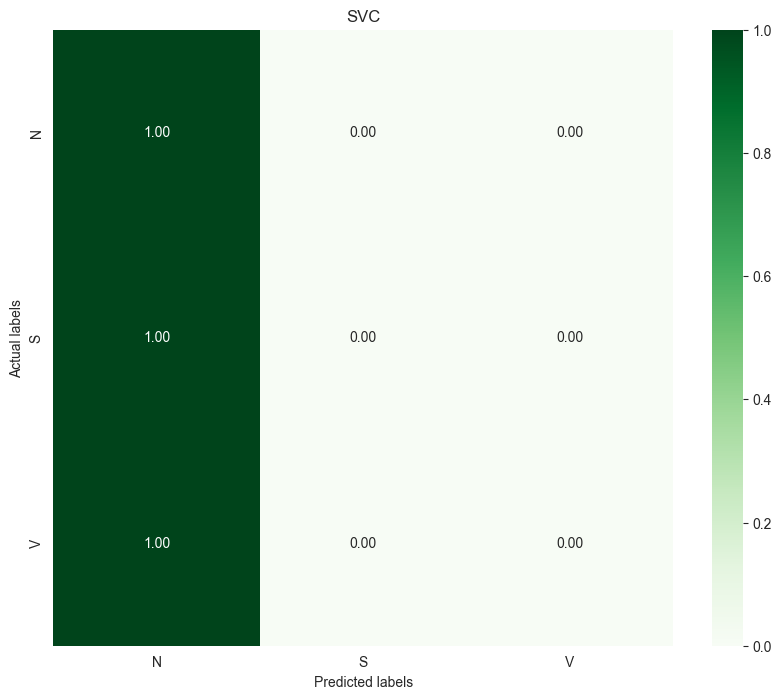

In [26]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear') 
 
# fitting x samples and y classes 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
    
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])
model_evaluation(one_hot_encoded_pred, "SVC")

# Random Forest

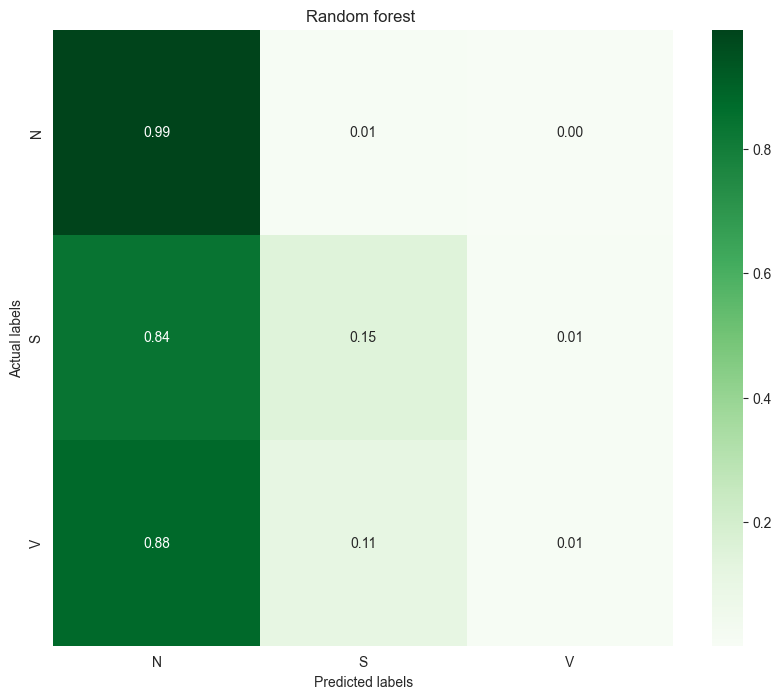

In [24]:
from sklearn.ensemble import RandomForestClassifier

    
randomForestModel = RandomForestClassifier(n_estimators=50,
                                            criterion='gini',
                                            max_depth=15,
                                            min_samples_split=22,
                                            class_weight=class_weights,
                                            n_jobs=-1,
                                            )
    
    
randomForestModel.fit(X_train, y_train)
y_pred = randomForestModel.predict(X_test)
    
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])
model_evaluation(one_hot_encoded_pred, "Random forest ")

# Balanced random forest

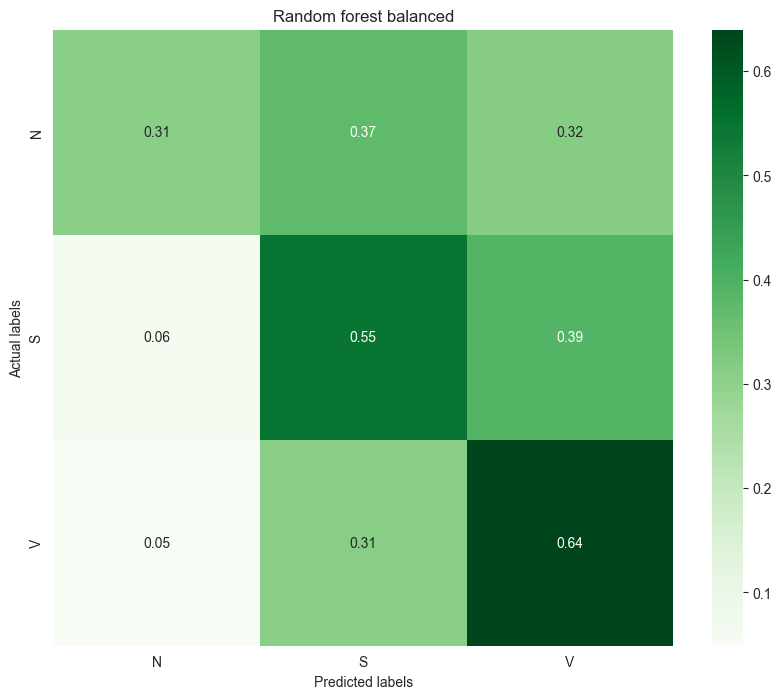

In [23]:
from imblearn.ensemble import BalancedRandomForestClassifier
BalancedRandomForestModel = BalancedRandomForestClassifier(n_estimators= 100,
                                                   criterion= 'gini',
                                                   max_depth= 20,
                                                   min_samples_split= 30,
                                                   min_samples_leaf = 1,
                                                   min_weight_fraction_leaf = 0.0,
                                                   max_features= None,
                                                   sampling_strategy='not minority',
                                                   replacement= False,
                                                   n_jobs= -1,
                                                   random_state=100,
                                                   class_weight= class_weights,
                                                
                                                   bootstrap=True
                                                   )
BalancedRandomForestModel.fit(X_train, 
              y_train)
y_pred = BalancedRandomForestModel.predict(X_test)
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])

model_evaluation(one_hot_encoded_pred, "Random forest balanced")

# AdaBoost

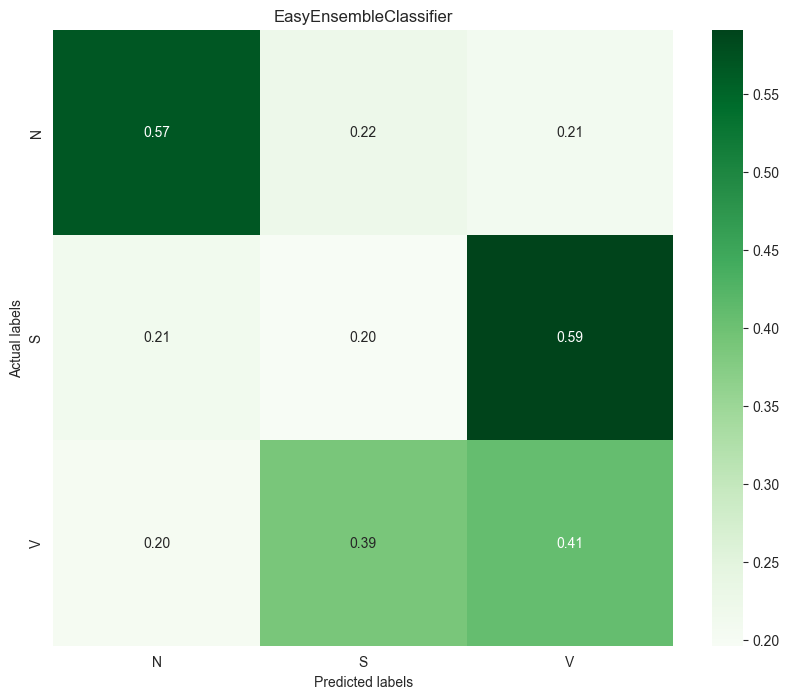

In [19]:

from imblearn.ensemble import EasyEnsembleClassifier

modelEasyEns = EasyEnsembleClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      random_state=42,
                                      sampling_strategy='majority',
                                      estimator=None
                                      )
modelEasyEns.fit(X_train, 
                 y_train)

y_predEasyEns = modelEasyEns.predict(X_test)
one_hot_encoded_pred_ens = pd.get_dummies(y_predEasyEns, columns=['0'])

model_evaluation(one_hot_encoded_pred_ens, "EasyEnsembleClassifier")